# Google Trend Prediction: Using Convolution Operator on Time Series 

I have prepared this notebook as an exercise while learning PyTorch. I have used the Google Trend results for the word *diet* and used Fully-Connected Neural Networks (FCNN) and Convolutional Neural Network (CNN) to predict the trend value for the following time period.

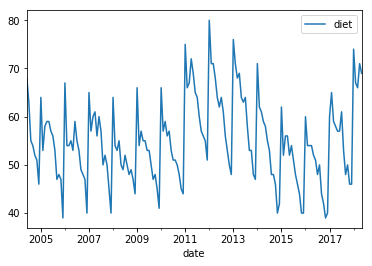

In [8]:
# Readers interested in dowloanding the dataset from the internet can use the pytrends library

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./diet.csv', names=['date', 'diet'])
df = df[2:]
df.diet = df.diet.astype('int64')
df.date = pd.to_datetime(df.date)
df = df.set_index('date')
df2 = df[5:]

df2.plot()
plt.show()

We can observe the cylical nature of the dataset. Let's see how NNs will perform.

# Preprocessing

To train and test the model, I need to seperate the the input and the output space. For this example, I will use the current and *5* previous observations to predict the next observation. The *prep* function returns a list of tuples where the first element is the input and the second is the target variable(s). I have used minmax normalization to prevent gradients from exploding while training the model. 

Any custom function implemented in this notebook can be accessed from the NeuralNetworks.py file accompanying this notebook. 

In [2]:
import NeuralNetworks
import importlib
importlib.reload(NeuralNetworks);

preperation = NeuralNetworks.Preprocessing(data=df2)
raw = preperation.prep(previous=5, future=1, normalize='minmax')

In [3]:
raw[0]

(tensor([ 0.7073,  0.5854,  0.3902,  0.3659,  0.3171,  0.2927], dtype=torch.float64),
 tensor([ 0.1707], dtype=torch.float64))

# Models

The architecture of each NN is as following:

- **FCNN**: A NN with 6 input units, 20 and 15 hidden units in the first and second hidden layers and 1 output unit. This model is implemented by the *FCNet* function.  
- **CNN**: This network is similar to FCNN, but the only difference is that in the first layer, I apply the convolution operator and then aggregate the results using an average pool. The model has 6 input units but this value changes based on the kernel and stride size chosen for the convoltion and pooling operators. The first hidden layer has 20 hidden units and the second layer has 10 hidden units and again a single output unit. This model is implemented in the *ConvNet* function. 

I have experimented with different hyperparameters such as the number of hidden units, the activation function of the hidden layers, batch size and the learning rate to build a model with the stongest results. These experimentations are omitted from this notebook. 

The results in this notebook is derived by training the models for 75 epochs with a batch size of 20 and a learning rate of 0.03. I have used Adam to optimize the weights, which adjusts the learning rate while the a model is being trained. I have used mean-square-error as my loss function. Finally, I have repeated the experiments 75 times to minimize the impact of random initializations on the results.

# Results

In [4]:
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

num_epochs=75
batch_size=20
learning_rate=0.03
repeat = 75
results = pd.DataFrame(columns=['FCNN', 'CNN'])
train_loader = data.DataLoader(dataset=raw[0:120], batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=raw[120:170], batch_size=1, shuffle=False)

loss=F.mse_loss

for i in range(repeat):
    temp = pd.DataFrame(columns=['FCNN', 'CNN'])
    
    FCNN = NeuralNetworks.FCNet(units=[6, 20, 15, 1], activation=F.tanh)
    CNN = NeuralNetworks.ConvNet(units = [6, 20, 10, 1], convKernel=3, poolKernel= 3, activation=F.tanh)
    
    Processing1 = NeuralNetworks.Processing(model=FCNN, epochs = num_epochs, 
                                            opt = optim.Adam(FCNN.parameters(), lr=learning_rate), loss=loss)
    
    Processing2 = NeuralNetworks.Processing(model=CNN, epochs = num_epochs, 
                                            opt = optim.Adam(CNN.parameters(), lr=learning_rate), loss=loss)
    
    Processing1.train(train_loader=train_loader)
    Processing2.train(train_loader=train_loader)
    
    _, rmse1 = Processing1.test(test_loader=test_loader)
    _, rmse2 = Processing2.test(test_loader=test_loader)
    
    temp.loc[0] = [rmse1, rmse2]
    results = results.append(temp)

results = results.reset_index(drop=True);

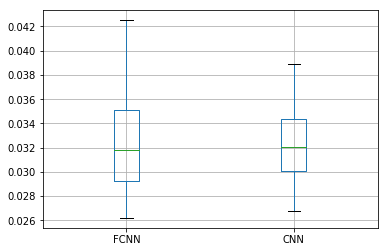

In [7]:
results.boxplot(showfliers=False)
plt.show()

In [6]:
import scipy.stats
scipy.stats.ttest_ind(results.FCNN, results.CNN)

Ttest_indResult(statistic=-0.4285301197865532, pvalue=0.6688882440647164)

The t-test confirms what we can observe in the boxplot, which is the true mean of the results are statistically indifferent. I was expecting CNN to have a lower MSE since it can capture local patterns. In image processing, randomly initialized convolutions work just as well as designed ones. For time series, designing a convolution might be required to identify patterns. Furthermore, I have not experimented too much with convolution and pooling operators' kernel size and other related hyperparameters. 

# Next Steps

In the next iteration of this notebook, I will look into one of the following models/improvements:
* Incorporating embeddings into fully connected network to teach seasonal patterns
* Recurrent Neural Networks (with and without LSTM)
* Implement Residual Learning and incoporate it to CNN
* Designer convolutions for CNN